In [3]:
import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats

In [4]:
import dynchro

In [5]:
%load_ext autoreload
%autoreload 2

# 1. Data loading

In [6]:
adata = ad.read_h5ad("data/processed_wildtype.h5ad")
irf8 = ad.read_h5ad("data/processed_irf8.h5ad")
gfi1 = ad.read_h5ad("data/processed_gfi1.h5ad")
both = ad.read_h5ad("data/processed_both.h5ad")

In [7]:
lineages = {"erythrocytic": [2, 1], "monocytic": [2, 0, 4], "granulocytic": [2, 0, 3]}
adata, irf8, gfi1, both, lineages

(AnnData object with n_obs × n_vars = 382 × 500
     obs: 'label', 'n_counts', 'n_genes', 'pct_genes', 'kmeans', 'node', 'branch_id', 'branch_id_alias', 'branch_lam', 'branch_dist', 'S0_pseudotime', 'S3_pseudotime', 'S5_pseudotime', 'S4_pseudotime', 'S2_pseudotime', 'S1_pseudotime', 'branch_id_id', 'pseudotime', 'milestones'
     var: 'n_counts', 'n_cells', 'pct_cells'
     uns: 'branch_id_alias_colors', 'label_colors', 'lineages', 'var_genes', 'workdir'
     obsm: 'X_dr', 'X_mlle', 'X_spring', 'X_stream_S4', 'X_vis', 'X_vis_umap',
 AnnData object with n_obs × n_vars = 62 × 500
     obs: 'label', 'pseudotime'
     uns: 'label_color', 'label_colors', 'params', 'var_genes', 'workdir'
     obsm: 'X_dr', 'X_mlle', 'X_pca', 'X_vis', 'X_vis_umap', 'var_genes',
 AnnData object with n_obs × n_vars = 79 × 500
     obs: 'label', 'pseudotime'
     uns: 'label_color', 'label_colors', 'params', 'var_genes', 'workdir'
     obsm: 'X_dr', 'X_mlle', 'X_pca', 'X_vis', 'X_vis_umap', 'var_genes',
 AnnData

# 2. Dynchro

## 2.1 Prep samples

In [11]:
# Run lineage prep on adata
adata.uns["id"] = "wildtype"
adata.uns["lineages"] = lineages
adata.obs["milestones"] = adata.obs["branch_id_id"]
for name, labels in lineages.items():
    adata = dynchro.pp.label_lineage(adata, "milestones", labels, name)
# for name, labels in lineages.items():
    # adata = dynchro.pp.calculate_pseudocells(adata, 50, name)
# adata = dynchro.pp.merge_pseudocells_lineages(adata, list(lineages.keys()), 50)
adata

/tmp/ipykernel_177026/2532049085.py:2: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["id"] = "wildtype"


AnnData object with n_obs × n_vars = 279 × 500
    obs: 'label', 'n_counts', 'n_genes', 'pct_genes', 'kmeans', 'node', 'branch_id', 'branch_id_alias', 'branch_lam', 'branch_dist', 'S0_pseudotime', 'S3_pseudotime', 'S5_pseudotime', 'S4_pseudotime', 'S2_pseudotime', 'S1_pseudotime', 'branch_id_id', 'pseudotime', 'milestones', 'erythrocytic', 'monocytic', 'granulocytic'
    var: 'n_counts', 'n_cells', 'pct_cells'
    uns: 'branch_id_alias_colors', 'label_colors', 'lineages', 'var_genes', 'workdir', 'id', 'lineage_labels'
    obsm: 'X_dr', 'X_mlle', 'X_spring', 'X_stream_S4', 'X_vis', 'X_vis_umap'

In [12]:
# Run lineage prep on irf8, gfi1, both
irf8.uns["id"] = "irf8"
gfi1.uns["id"] = "gfi1"
both.uns["id"] = "both"

for a in [irf8, gfi1, both]:
    a.uns["lineages"] = lineages
    a.obs["milestones"] = 1
    a = dynchro.pp.label_lineage(a, "milestones", [1], a.uns["id"])
    # a = dynchro.pp.calculate_pseudocells(a, 50, a.uns["id"])

irf8, gfi1, both

(AnnData object with n_obs × n_vars = 62 × 500
     obs: 'label', 'pseudotime', 'milestones', 'irf8'
     uns: 'label_color', 'label_colors', 'params', 'var_genes', 'workdir', 'id', 'lineages', 'lineage_labels'
     obsm: 'X_dr', 'X_mlle', 'X_pca', 'X_vis', 'X_vis_umap', 'var_genes',
 AnnData object with n_obs × n_vars = 79 × 500
     obs: 'label', 'pseudotime', 'milestones', 'gfi1'
     uns: 'label_color', 'label_colors', 'params', 'var_genes', 'workdir', 'id', 'lineages', 'lineage_labels'
     obsm: 'X_dr', 'X_mlle', 'X_pca', 'X_vis', 'X_vis_umap', 'var_genes',
 AnnData object with n_obs × n_vars = 47 × 500
     obs: 'label', 'pseudotime', 'milestones', 'both'
     uns: 'label_color', 'label_colors', 'params', 'var_genes', 'workdir', 'id', 'lineages', 'lineage_labels'
     obsm: 'X_dr', 'X_mlle', 'X_pca', 'X_vis', 'X_vis_umap', 'var_genes')

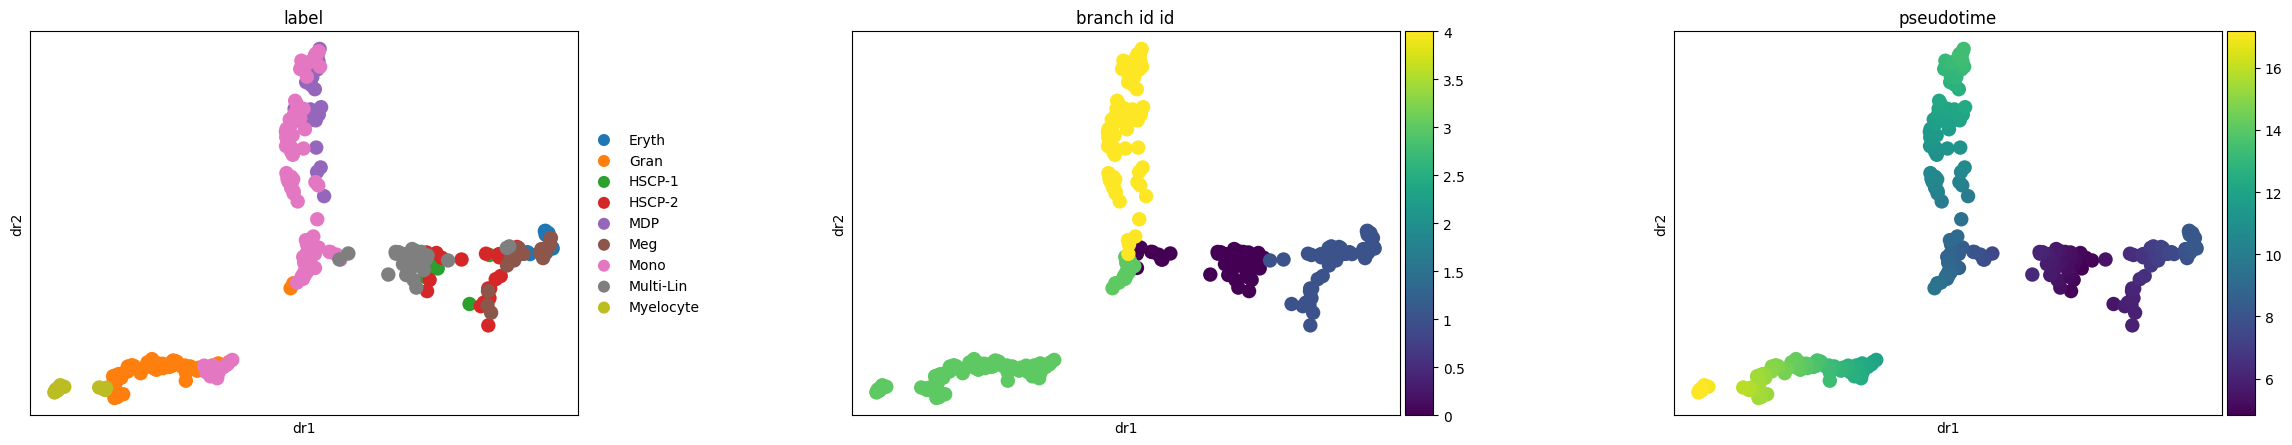

In [13]:
sc.pl.scatter(adata, color=['label', 'branch_id_id', 'pseudotime'], basis='dr')

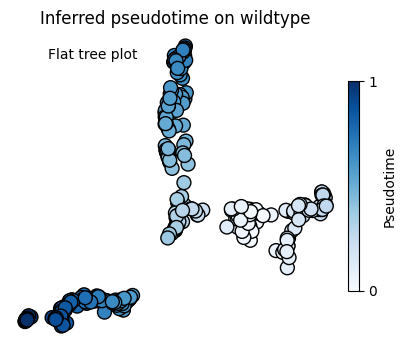

In [136]:
xs = adata.obsm['X_dr'][:, 0]
ys = adata.obsm['X_dr'][:, 1]
colors = adata.obs['pseudotime'].values
norm_colors = (colors - colors.min()) / (colors.max() - colors.min())
fig, ax = plt.subplots(figsize=(4.5, 4))
ax.scatter(xs, ys, c=norm_colors, cmap='Blues', s=100, edgecolors = 'k')

# fig = sc.pl.scatter(adata, color="pseudotime", basis='dr', color_map='Blues', show=False)
# ax = fig.axes

ax.set_title("Inferred pseudotime on wildtype")

ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
ax.set_xlabel("Flat tree plot")
ax.set_xticks([])
ax.set_yticks([])
ax.xaxis.set_label_coords(0.25, 0.95)
ax.set_ylabel("")
plt.colorbar(ax.collections[0], label='Pseudotime', orientation='vertical', fraction=0.03, ticks = [0, 1], pad=0.02)

In [ ]:
from matplotlib import colors


NotImplementedError: Abstract class only

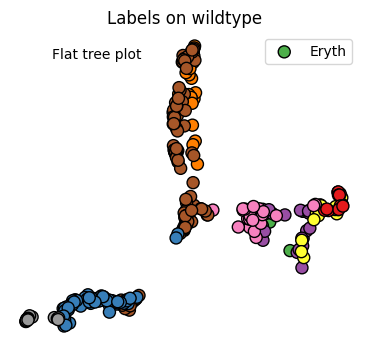

In [160]:
xs = adata.obsm['X_dr'][:, 0]
ys = adata.obsm['X_dr'][:, 1]
colors = adata.obs['label'].values
# colors to numbers
color_map = {label: i for i, label in enumerate(np.unique(colors))}
colors = np.array([color_map[c] for c in colors])
fig, ax = plt.subplots(figsize=(4.5, 4))
ax.scatter(xs, ys, c=colors, cmap='Set1', s=75, edgecolors = 'k')

# fig = sc.pl.scatter(adata, color="pseudotime", basis='dr', color_map='Blues', show=False)
# ax = fig.axes
# ax.legend(
#     handles = [plt.Circle(color=color_map[label], xy=(0, 0), label=label, edgecolor='k', linewidth=0.5, facecolor='none', markersize=10) for label in color_map.keys()],
#     title="Lineages"
# )

ax.set_title("Labels on wildtype")

ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
ax.set_xlabel("Flat tree plot")
ax.set_xticks([])
ax.set_yticks([])
ax.xaxis.set_label_coords(0.25, 0.95)
ax.set_ylabel("")
# plot colormap as a legend
plt.legend(color_map.keys())
# ax.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label=label,
        #                     markerfacecolor=color_map[label], markersize=10) for label in color_map.keys()],
        #   title="Lineages",
        #   loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
# plt.colorbar(ax.collections[0], label='Pseudotime', orientation='vertical', fraction=0.03, ticks = [0, 1], pad=0.02)

## 2.2 Run dynchro

/home/louise/Work/dynchro/src/dynchro/tl/dtw.py:114: ImplicitModificationWarning: Setting element `.obsm['irf8_erythrocytic_irf8_cost']` of view, initializing view as actual.
  reference.obsm[f"{dtw_key}_cost"] = cost
/home/louise/Work/dynchro/src/dynchro/tl/dtw.py:118: ImplicitModificationWarning: Setting element `.obsm['irf8_erythrocytic_irf8_cost']` of view, initializing view as actual.
  query.obsm[f"{dtw_key}_cost"] = cost.T


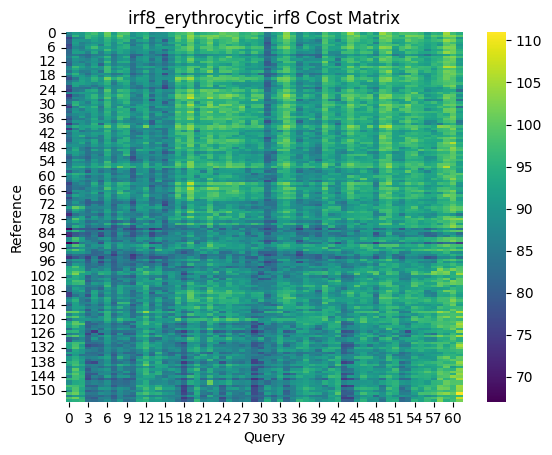

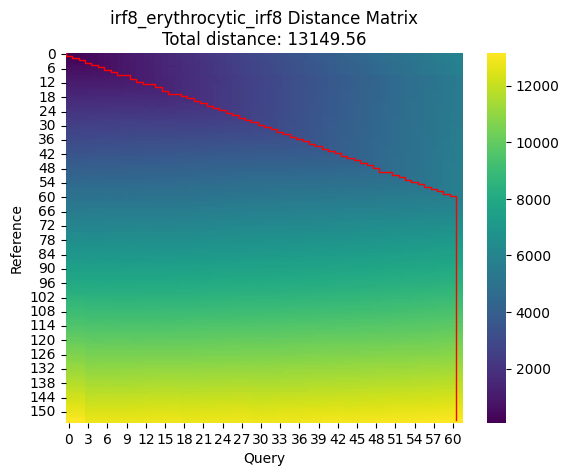

/home/louise/Work/dynchro/src/dynchro/tl/dtw.py:114: ImplicitModificationWarning: Setting element `.obsm['irf8_monocytic_irf8_cost']` of view, initializing view as actual.
  reference.obsm[f"{dtw_key}_cost"] = cost


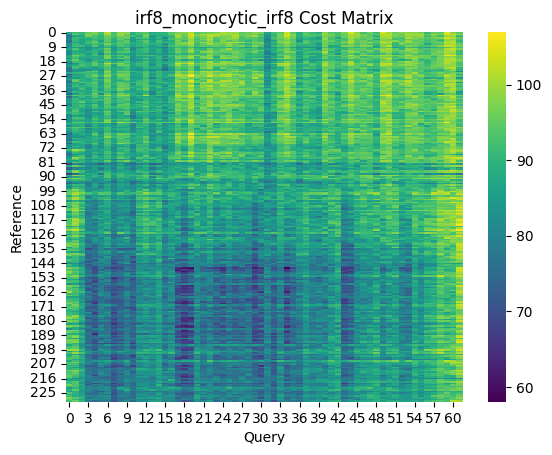

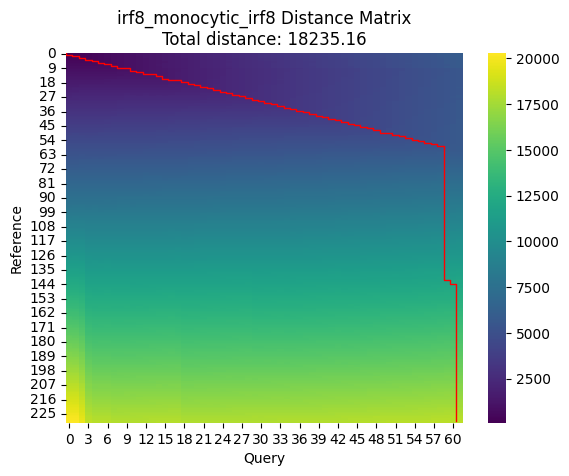

/home/louise/Work/dynchro/src/dynchro/tl/dtw.py:114: ImplicitModificationWarning: Setting element `.obsm['irf8_granulocytic_irf8_cost']` of view, initializing view as actual.
  reference.obsm[f"{dtw_key}_cost"] = cost


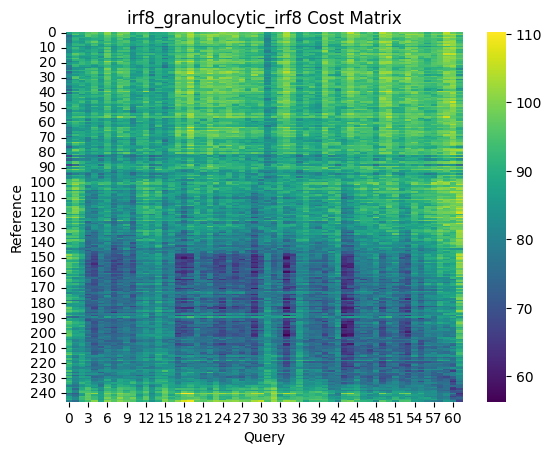

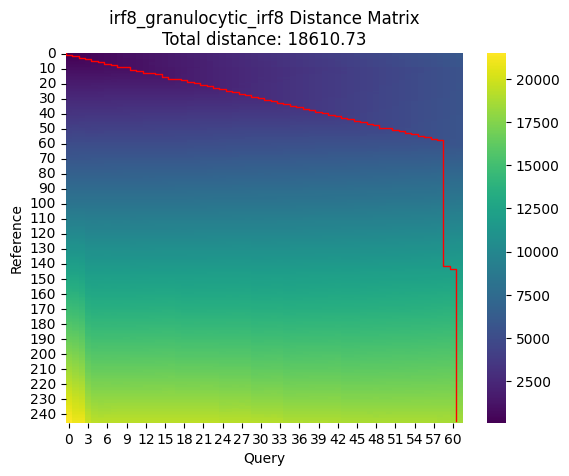

In [82]:
warping_irf8 = dynchro.tl.get_matching_lineages(adata, irf8, "irf8", mode = "copy", plot = True)

/home/louise/Work/dynchro/src/dynchro/tl/dtw.py:114: ImplicitModificationWarning: Setting element `.obsm['gfi1_erythrocytic_gfi1_cost']` of view, initializing view as actual.
  reference.obsm[f"{dtw_key}_cost"] = cost
/home/louise/Work/dynchro/src/dynchro/tl/dtw.py:118: ImplicitModificationWarning: Setting element `.obsm['gfi1_erythrocytic_gfi1_cost']` of view, initializing view as actual.
  query.obsm[f"{dtw_key}_cost"] = cost.T


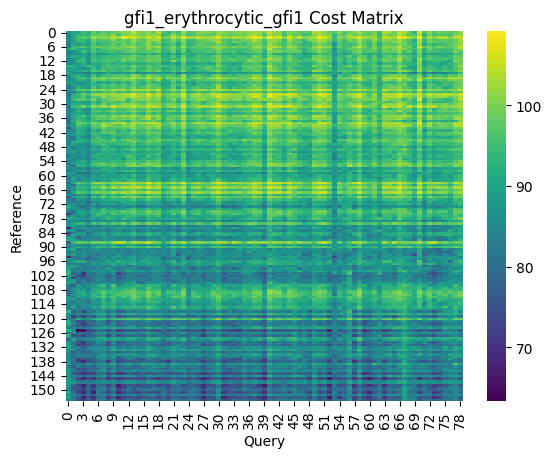

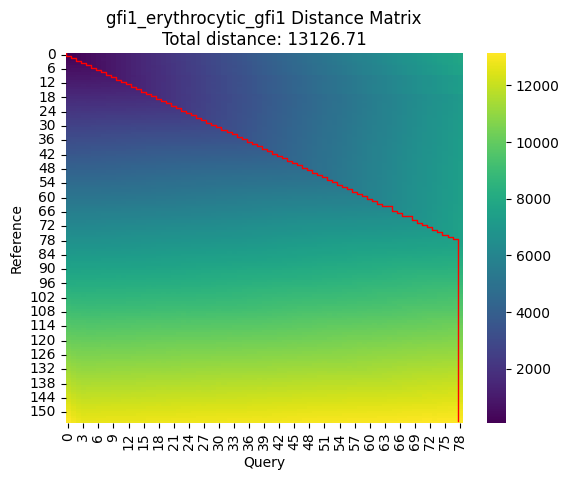

/home/louise/Work/dynchro/src/dynchro/tl/dtw.py:114: ImplicitModificationWarning: Setting element `.obsm['gfi1_monocytic_gfi1_cost']` of view, initializing view as actual.
  reference.obsm[f"{dtw_key}_cost"] = cost


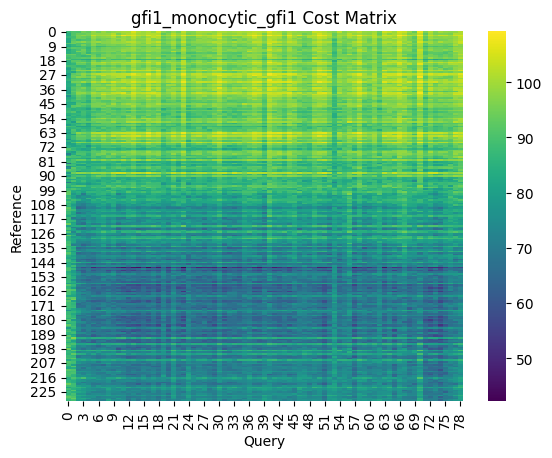

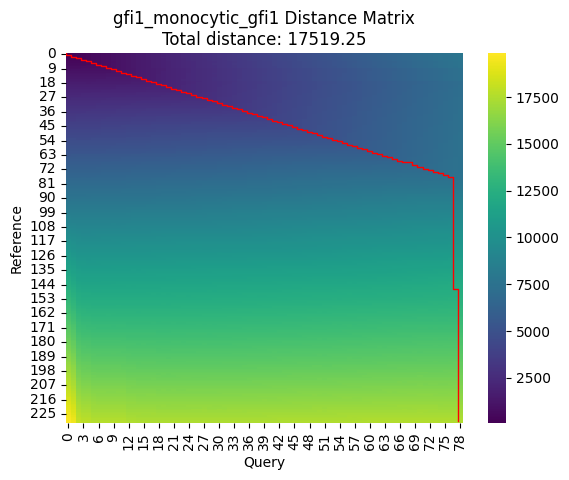

/home/louise/Work/dynchro/src/dynchro/tl/dtw.py:114: ImplicitModificationWarning: Setting element `.obsm['gfi1_granulocytic_gfi1_cost']` of view, initializing view as actual.
  reference.obsm[f"{dtw_key}_cost"] = cost


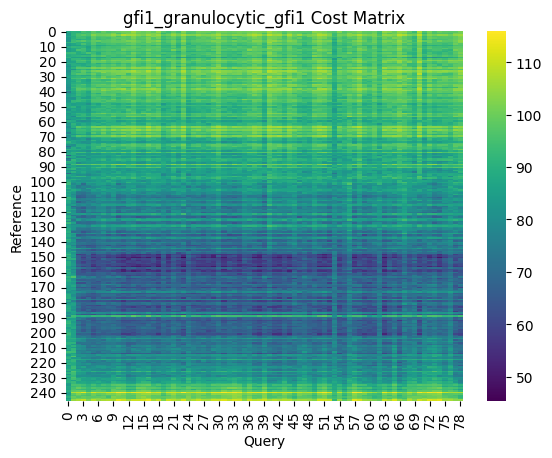

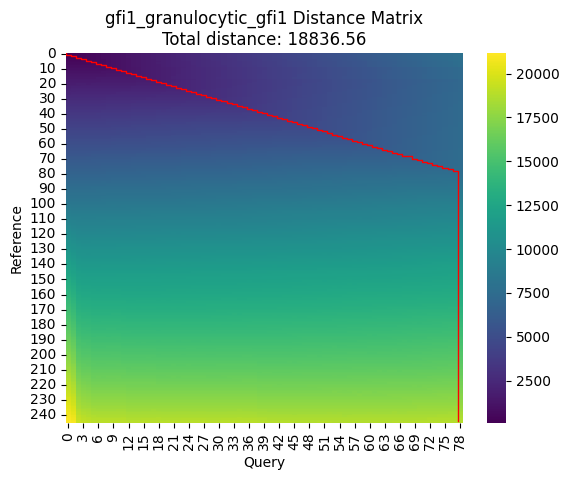

In [83]:
warping_gfi1 = dynchro.tl.get_matching_lineages(adata, gfi1, "gfi1", mode="copy", plot = True)

/home/louise/Work/dynchro/src/dynchro/tl/dtw.py:114: ImplicitModificationWarning: Setting element `.obsm['both_erythrocytic_both_cost']` of view, initializing view as actual.
  reference.obsm[f"{dtw_key}_cost"] = cost
/home/louise/Work/dynchro/src/dynchro/tl/dtw.py:118: ImplicitModificationWarning: Setting element `.obsm['both_erythrocytic_both_cost']` of view, initializing view as actual.
  query.obsm[f"{dtw_key}_cost"] = cost.T


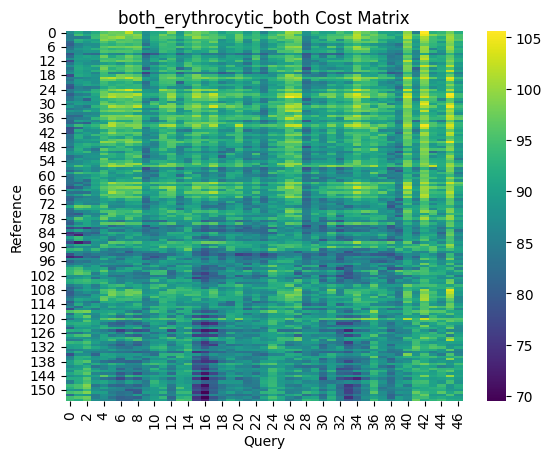

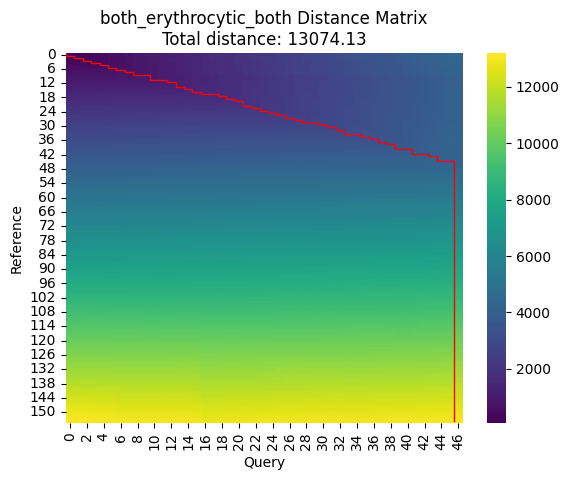

/home/louise/Work/dynchro/src/dynchro/tl/dtw.py:114: ImplicitModificationWarning: Setting element `.obsm['both_monocytic_both_cost']` of view, initializing view as actual.
  reference.obsm[f"{dtw_key}_cost"] = cost


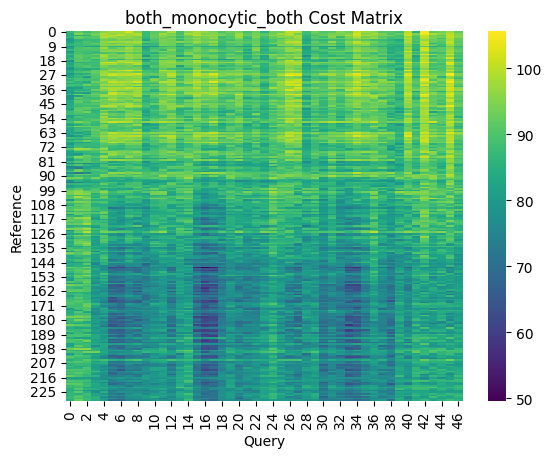

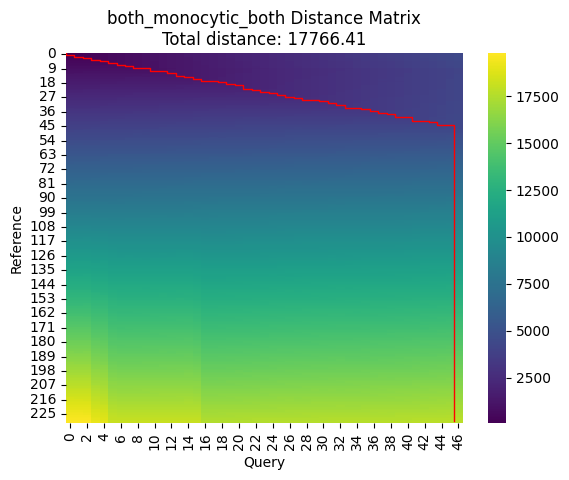

/home/louise/Work/dynchro/src/dynchro/tl/dtw.py:114: ImplicitModificationWarning: Setting element `.obsm['both_granulocytic_both_cost']` of view, initializing view as actual.
  reference.obsm[f"{dtw_key}_cost"] = cost


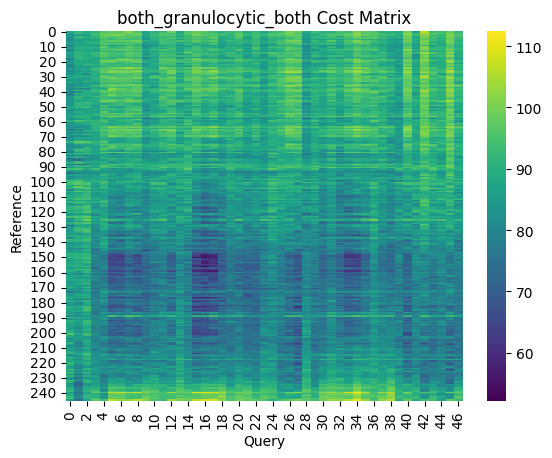

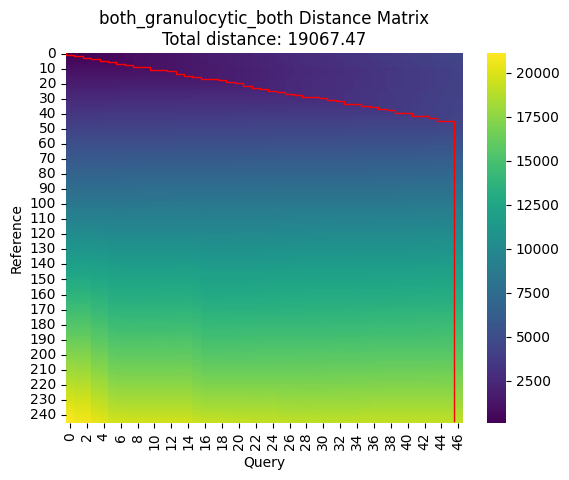

In [84]:
warping_both = dynchro.tl.get_matching_lineages(adata, both, "both", mode="copy", plot = True)

In [85]:
warping_irf8[2], warping_gfi1[2], warping_both[2]

(array([[1.36832027],
        [1.27322724],
        [1.22021599]]),
 array([[1.07200612],
        [0.96001134],
        [0.96925778]]),
 array([[1.79466405],
        [1.63640179],
        [1.64914978]]))

## 2.3 Plot average cost

In [78]:
warping_irf8[4][0].obsm["irf8_granulocytic_irf8_D"][-1,60:75]

array([5721.37541416, 5738.67466382, 5831.61297214, 5891.56067661,
       5967.70885553, 6060.98017146, 6135.71849253, 6191.08704036,
       6279.46054823, 6357.84877304, 6441.26098295, 6517.34861139,
       6600.15078156, 6699.4814092 , 6775.89838832])

In [86]:
gran = warping_irf8[3][2]
irf8_warped = warping_irf8[4][0]
dtw_label = "irf8_granulocytic_irf8"
gran = dynchro.tl.avg_cost_path(gran, dtw_key=dtw_label)
irf8_warped = dynchro.tl.avg_cost_path(irf8_warped, dtw_key=dtw_label)

<Axes: title={'center': 'Average Cost on Path'}, xlabel='Pseudotime', ylabel='Average Cost'>

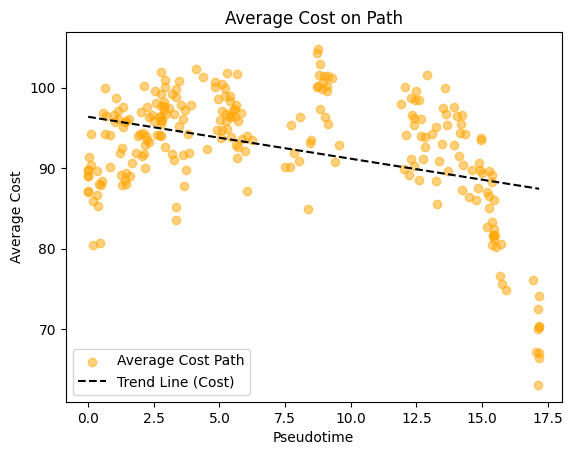

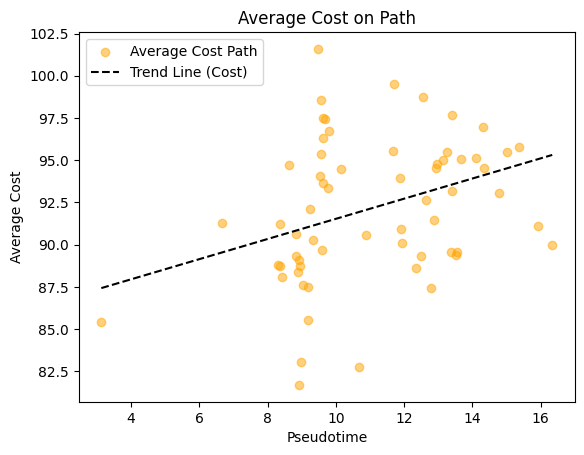

In [87]:
dynchro.pl.plot_avg_cost_path(gran, pseudotime_key="pseudotime", dtw_key=dtw_label)
dynchro.pl.plot_avg_cost_path(irf8_warped, pseudotime_key="pseudotime", dtw_key=dtw_label)

In [88]:
mono = warping_gfi1[3][1]
gfi1_warped = warping_gfi1[4][0]
dtw_label = "gfi1_monocytic_gfi1"
mono = dynchro.tl.avg_cost_path(mono, dtw_key=dtw_label)
gfi1_warped = dynchro.tl.avg_cost_path(gfi1_warped, dtw_key=dtw_label)

<Axes: title={'center': 'Average Cost on Path'}, xlabel='Pseudotime', ylabel='Average Cost'>

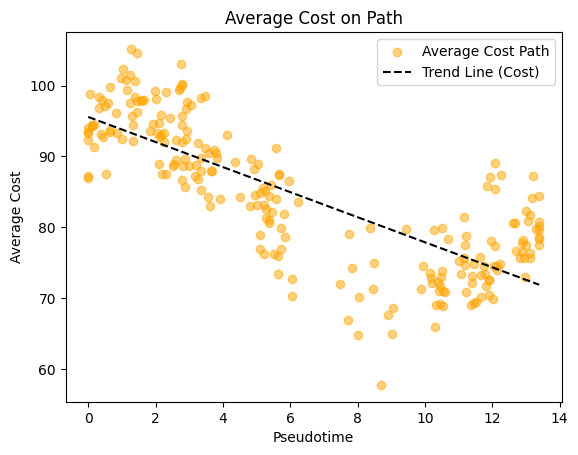

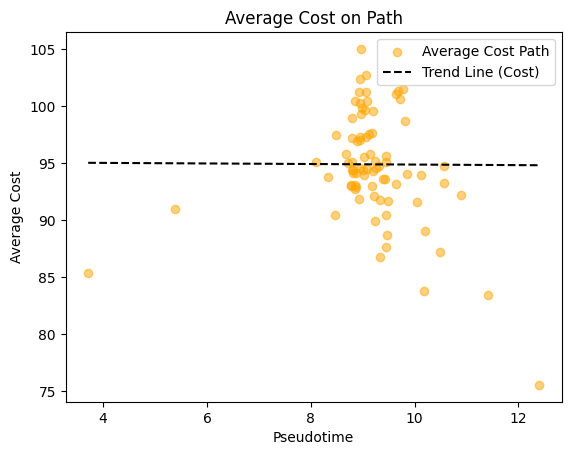

In [89]:
dynchro.pl.plot_avg_cost_path(mono, pseudotime_key="pseudotime", dtw_key=dtw_label)
dynchro.pl.plot_avg_cost_path(gfi1_warped, pseudotime_key="pseudotime", dtw_key=dtw_label)

In [90]:
ery = warping_irf8[3][0]
irf8_warped2 = warping_irf8[4][0]
dtw_label = "irf8_erythrocytic_irf8"
ery = dynchro.tl.avg_cost_path(ery, dtw_key=dtw_label)
irf8_warped2 = dynchro.tl.avg_cost_path(irf8_warped2, dtw_key=dtw_label)

<Axes: title={'center': 'Average Cost on Path'}, xlabel='Pseudotime', ylabel='Average Cost'>

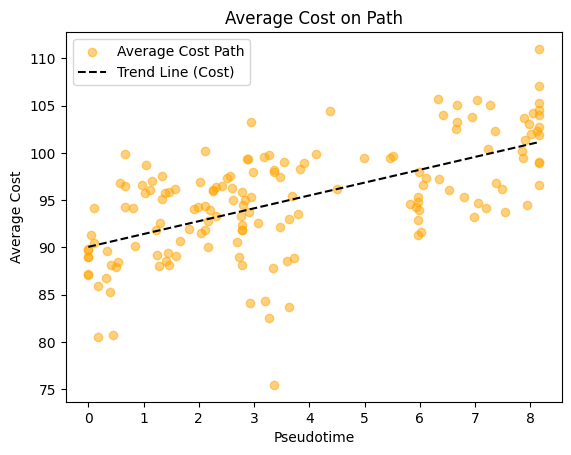

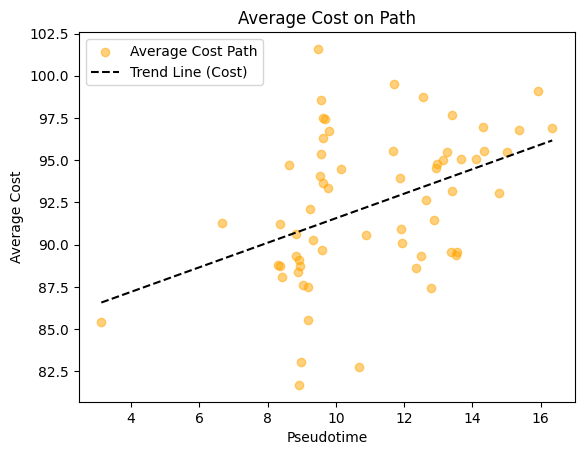

In [91]:
dynchro.pl.plot_avg_cost_path(ery, pseudotime_key="pseudotime", dtw_key=dtw_label)
dynchro.pl.plot_avg_cost_path(irf8_warped2, pseudotime_key="pseudotime", dtw_key=dtw_label)


## 2.4 Plot warping

In [20]:
wt_irf8 = warping_irf8[3][2]

warped_irf8 = warping_irf8[4][0]
wt_irf8, warped_irf8

(AnnData object with n_obs × n_vars = 246 × 268
     obs: 'label', 'n_counts', 'n_genes', 'pct_genes', 'kmeans', 'node', 'branch_id', 'branch_id_alias', 'branch_lam', 'branch_dist', 'S0_pseudotime', 'S3_pseudotime', 'S5_pseudotime', 'S4_pseudotime', 'S2_pseudotime', 'S1_pseudotime', 'branch_id_id', 'pseudotime', 'milestones', 'erythrocytic', 'monocytic', 'granulocytic', 'irf8_granulocytic_irf8_path', 'irf8_granulocytic_irf8_cells_path', 'irf8_granulocytic_irf8_avg_cost'
     var: 'n_counts', 'n_cells', 'pct_cells'
     uns: 'branch_id_alias_colors', 'label_colors', 'lineages', 'var_genes', 'workdir', 'id', 'lineage_labels', 'irf8_granulocytic_irf8_distance'
     obsm: 'X_dr', 'X_mlle', 'X_spring', 'X_stream_S4', 'X_vis', 'X_vis_umap', 'irf8_granulocytic_irf8_cost', 'irf8_granulocytic_irf8_D',
 AnnData object with n_obs × n_vars = 62 × 268
     obs: 'label', 'pseudotime', 'milestones', 'irf8', 'irf8_erythrocytic_irf8_path', 'irf8_erythrocytic_irf8_cells_path', 'irf8_monocytic_irf8_path'

In [21]:
erythrocytic = warping_irf8[3][0]
monocytic = warping_gfi1[3][1]
granulocytic = warping_irf8[3][2]

<Axes: xlabel='Pseudotime'>

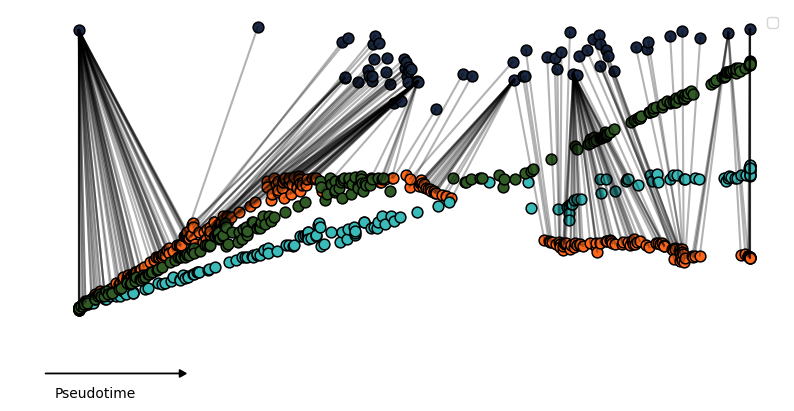

In [36]:
dynchro.pl.plot_warping(
    warped_datasets = [granulocytic, warped_irf8],
    extra_datasets = [erythrocytic, monocytic],
    dtw_key = "irf8_granulocytic_irf8",
    dimred_key = "X_vis_umap"
)

## 2.5 Bootstrap

In [52]:
adata = adata[adata.obs.branch_id_id.isin([0, 1, 3, 4])]
def calculate_distance_irf8(names):
    knockout = irf8[names]
    ri, ci, distances, lin1, lin2 = dynchro.tl.get_matching_lineages(adata, knockout, dtw_key = "irf8")
    return distances[:, 0]

def calculate_distance_gfi1(names):
    knockout = gfi1[names]
    ri, ci, distances, lin1, lin2 = dynchro.tl.get_matching_lineages(adata, knockout, dtw_key = "gfi1")
    return distances[:, 0]

def calculate_distance_both(names):
    knockout = both[names]
    ri, ci, distances, lin1, lin2 = dynchro.tl.get_matching_lineages(adata, knockout, dtw_key = "both")
    return distances[:, 0] 

In [53]:
res_irf8 = stats.bootstrap([irf8.obs_names], calculate_distance_irf8, n_resamples= 100, vectorized=False, axis = 0)
results_irf8 = res_irf8.bootstrap_distribution
res_gfi1 = stats.bootstrap([gfi1.obs_names], calculate_distance_gfi1, n_resamples= 100, vectorized=False, axis = 0)
results_gfi1 = res_gfi1.bootstrap_distribution
res_both = stats.bootstrap([both.obs_names], calculate_distance_both, n_resamples= 100, vectorized=False, axis = 0)
results_both = res_both.bootstrap_distribution

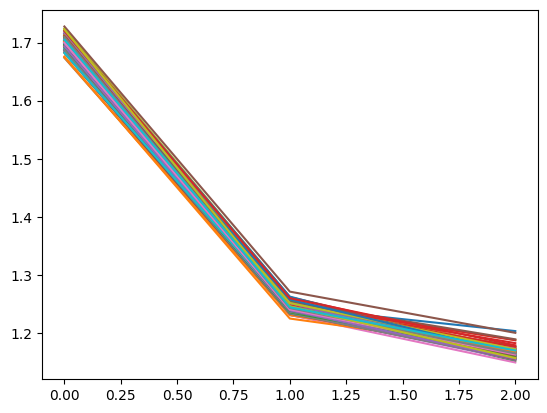

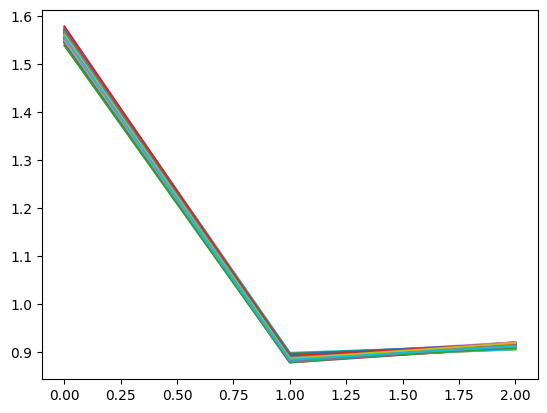

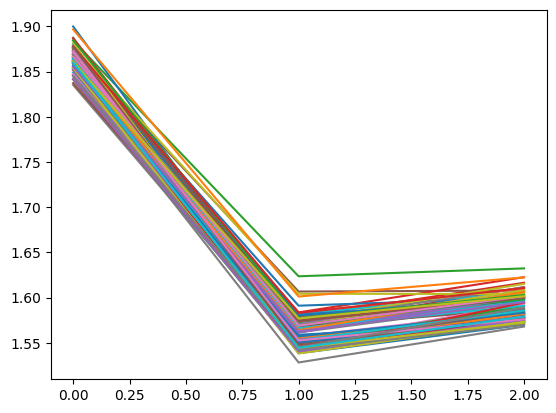

In [54]:
# for each three values, plot a line plot
for i, g, b in zip(results_irf8[0], results_irf8[1], results_irf8[2]):
    plt.plot([i, g, b])

plt.show()

# for each three values, plot a line plot
for i, g, b in zip(results_gfi1[0], results_gfi1[1], results_gfi1[2]):
    plt.plot([i, g, b])

plt.show()
for i, g, b in zip(results_both[0], results_both[1], results_both[2]):
    plt.plot([i, g, b])

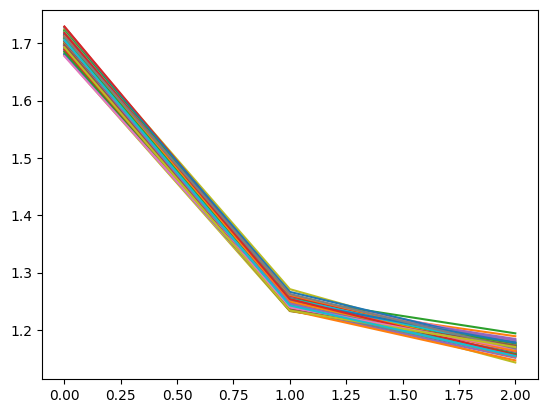

IndexError: index 1 is out of bounds for axis 0 with size 1

In [51]:
results_irf8 = res.bootstrap_distribution

# for each three values, plot a line plot
for i, g, b in zip(results_irf8[0], results_irf8[1], results_irf8[2]):
    plt.plot([i, g, b])

plt.show()

results_gfi1 = res_gfi1.bootstrap_distribution

# for each three values, plot a line plot
for i, g, b in zip(results_gfi1[0], results_gfi1[1], results_gfi1[2]):
    plt.plot([i, g, b])

plt.show()
results_both = res_both.bootstrap_distribution

for i, g, b in zip(results_both[0], results_both[1], results_both[2]):
    plt.plot([i, g, b])

In [55]:
irf8_data = pd.DataFrame({"erythrocytic": results_irf8[0], "monocytic": results_irf8[1], "granulocytic": results_irf8[2], "id": range(len(results_irf8[0]))}).melt(id_vars = "id")
# rename variable to branch and value to normalised distance
irf8_data = irf8_data.rename(columns = {"variable": "branch", "value": "normalised_distance"})
irf8_data

,id,branch,normalised_distance
0,0,erythrocytic,1.688475
1,1,erythrocytic,1.687058
2,2,erythrocytic,1.713455
3,3,erythrocytic,1.704345
4,4,erythrocytic,1.701182
...,...,...,...
295,95,granulocytic,1.160827
296,96,granulocytic,1.162709
297,97,granulocytic,1.164583
298,98,granulocytic,1.156542


In [56]:
gfi1_data = pd.DataFrame({"erythrocytic": results_gfi1[0], "monocytic": results_gfi1[1], "granulocytic": results_gfi1[2], "id": range(len(results_gfi1[0]))}).melt(id_vars = "id")
# rename variable to branch and value to normalised distance
gfi1_data = gfi1_data.rename(columns = {"variable": "branch", "value": "normalised_distance"})
gfi1_data

,id,branch,normalised_distance
0,0,erythrocytic,1.575712
1,1,erythrocytic,1.570815
2,2,erythrocytic,1.547170
3,3,erythrocytic,1.564335
4,4,erythrocytic,1.564699
...,...,...,...
295,95,granulocytic,0.911140
296,96,granulocytic,0.911398
297,97,granulocytic,0.910659
298,98,granulocytic,0.918198


In [57]:
both_data = pd.DataFrame({"erythrocytic": results_both[0], "monocytic": results_both[1], "granulocytic": results_both[2], "id": range(len(results_both[0]))}).melt(id_vars = "id")
# rename variable to branch and value to normalised distance
both_data = both_data.rename(columns = {"variable": "branch", "value": "normalised_distance"})
both_data

,id,branch,normalised_distance
0,0,erythrocytic,1.859164
1,1,erythrocytic,1.866611
2,2,erythrocytic,1.884307
3,3,erythrocytic,1.875615
4,4,erythrocytic,1.877876
...,...,...,...
295,95,granulocytic,1.578094
296,96,granulocytic,1.576067
297,97,granulocytic,1.589045
298,98,granulocytic,1.601542


In [58]:
%load_ext rpy2.ipython

In [67]:
%%R
install.packages("ggstatsplot")

* installing *source* package ‘ggstatsplot’ ...
** this is package ‘ggstatsplot’ version ‘0.13.1’
** package ‘ggstatsplot’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** data
*** moving datasets to lazyload DB
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (ggstatsplot)


TypeError: ZMQDisplayPublisher.publish() got an unexpected keyword argument 'source'

In [64]:
%%R -i gfi1_data
library("ggstatsplot")
library("ggplot2")
p1 <- ggwithinstats(gfi1_data, x = branch, y = normalised_distance, title = "GFI1 knockout", xlab = "Branch", ylab = "Normalised distance")
ggsave("gfi1_knockout.pdf", p1)

Saving 6.67 x 6.67 in image


In [65]:
%%R -i both_data
p2 <- ggwithinstats(both_data, x = branch, y = normalised_distance, title = "GFI1 and IRF8 knockout", xlab = "Branch", ylab = "Normalised distance")
ggsave("both_knockout.pdf", p2)

Saving 6.67 x 6.67 in image


In [66]:
%%R -i irf8_data
p3 <- ggwithinstats(irf8_data, x = branch, y = normalised_distance, title = "IRF8 knockout", xlab = "Branch", ylab = "Normalised distance")
ggsave("irf8_knockout.pdf", p3)

Saving 6.67 x 6.67 in image
